# **Toxic Comment Classification**

## Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

from keras.models import Sequential
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM, GRU, Bidirectional

## Importing the dataset

https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data

In [2]:
'''
import shutil
import os
shutil.copy('/content/drive/MyDrive/data.csv', os.getcwd())
'''

"\nimport shutil\nimport os\nshutil.copy('/content/drive/MyDrive/data.csv', os.getcwd())\n"

In [3]:
dataSet = pd.read_csv('data.csv')

In [4]:
X = dataSet['X'].values

In [5]:
y = dataSet['y'].values

## Splitting the dataset into the Training set and Test set

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

## Tokenization

In [7]:
num_words = 20000

tokenizer = Tokenizer(num_words = num_words)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [8]:
vocab_size = len(tokenizer.word_index) + 1

vocab_size

107152

## Embedding

In [9]:
maxlen = 200

X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)

In [10]:
X_train.shape

(111659, 200)

## LSTM

### Setting the seed

In [11]:
seed_value = 187372311

import random
random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

np.random.seed(seed_value)

import os
os.environ['PYTHONHASHSEED']=str(seed_value)

### Building the model

In [12]:
embedding_dim = 128

# Initialising the model
model = Sequential()

# Adding Embedding layer
model.add(Embedding(input_dim = vocab_size, 
                    output_dim = embedding_dim, 
                    input_length = maxlen))

# Adding LSTM layer
model.add(LSTM(100))

# Adding the output layer
model.add(Dense(1, activation='sigmoid'))

# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          13715456  
_________________________________________________________________
lstm (LSTM)                  (None, 100)               91600     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 13,807,157
Trainable params: 13,807,157
Non-trainable params: 0
_________________________________________________________________


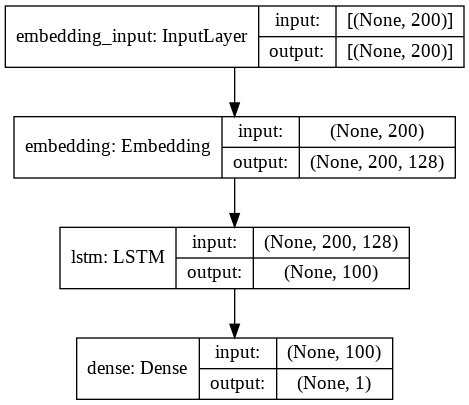

In [14]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='LSTM.png', show_shapes=True, show_layer_names=True)

In [15]:
# Fitting the model to the Training set
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=128)

Epoch 1/2
873/873 [==============================] - 135s 151ms/step - loss: 0.2110 - accuracy: 0.9296 - val_loss: 0.1072 - val_accuracy: 0.9613
Epoch 2/2
873/873 [==============================] - 131s 150ms/step - loss: 0.0865 - accuracy: 0.9692 - val_loss: 0.1085 - val_accuracy: 0.9628


### Making the predictions and visualising the results

In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

def report(y_test, y_pred):

  cm = confusion_matrix(y_test, y_pred)

  acc = np.round(accuracy_score(y_test, y_pred)*100, 2)
  p = np.round(precision_score(y_test, y_pred)*100, 2)
  r = np.round(recall_score(y_test, y_pred)*100, 2)
  f1 = np.round(f1_score(y_test, y_pred)*100, 2)

  data = [acc, p, r, f1]

  idx = ['Accuracy', 'Precision', 'Recall', 'F1']
  results = pd.DataFrame(index=idx, data = data, columns=['Value'])
  results.index.name = 'Metric'
  display(results)

  plt.figure(figsize=(7, 5))
  sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt = 'd', annot_kws={"size": 30}).set_title('Confusion Matrix')
  plt.show()

,Value
Metric,
Accuracy,96.28
Precision,89.49
Recall,71.76
F1,79.65


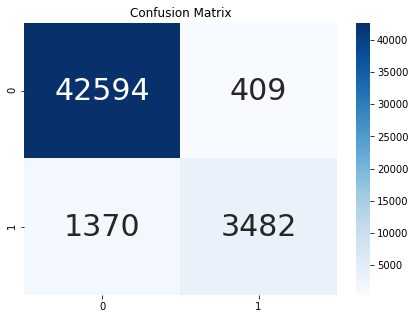

In [17]:
y_pred = model.predict(X_test) > 0.5

report(y_test, y_pred)

### Saving the model

In [18]:
model.save('LSTM.h5')